# Writing a Simple Feed Forward Neural Network in Julia

In [7]:
using Plots
using Flux
using Random
using Zygote #Packages for Automatic Differentiation and Neural Networks (i.e. Tensorflow for Julia)

## Architecture and Construct Network 

In [15]:
struct Layer
    W::Matrix{Float32} #weight matrix; Float32 for faster gradients
    b::Vector{Float32} #bias vector
    activation::Function
    Layer(in::Int64,out::Int64,activation::Function=identityFunction) = new(randn(out,in),randn(out),activation) #constructor
end
(m::Layer)(x) = m.activation.(m.W*x .+ m.b) #feed-forward pass

ReLu(x) = max(0,x)
identityFunction(x) = x

struct Network
    layers::Vector{Layer} 
    Network(layers::Vararg{Layer}) = new(vcat(layers...)) #constructor; allow arbitrarily many layers
end
(m::Network)(x) = reduce((left,right)->right∘left,m.layers)(x) #perform layer-wise operations over arbitrarily many layers


## Component by Component breakdown of the Network

### 1. Writing a feedforward layer as a Julia struct

This is the standard setup for a feedforward layer. We need a `weight matrix`, `W`, a `bias vector`, `b`, and an `activation function`.

>struct Layer<br>
>&emsp;&emsp;W::Matrix{Float32} #weight matrix; Float32 for faster gradients<br>
>&emsp;&emsp;b::Vector{Float32} #bias vector<br>
>&emsp;&emsp;activation::Function<br>
>&emsp;&emsp;Layer(in::Int64,out::Int64,activation::Function=identityFunction) = >new(randn(out,in),randn(out),activation) #constructor<br>
>end

### 2. Define the Feed Forward pass of the FeedForward layer

NOTE: Julia allows us to call a function via an instantiated struct. This makes later usage of layer and network instances more elegant.<br><br>
The implementation of the identity activation functions should be clear


> (m::Layer)(x) = m.activation.(m.W*x .+ m.b) #feed-forward pass

### 3. Aggregating layers into a full feedforward Neural Network
The network itself is simply a collection of its individual layers:<br>

We use a `Vararg` argument in the constructor to allow for an arbitrary amount of layers. While we could just use a Vector in the constructor call, this approach saves us two brackets there

>struct Network<br>
>&emsp;&emsp;layers::Vector{Layer}<br>
>&emsp;&emsp;Network(layers::Vararg{Layer}) = new(vcat(layers...)) #constructor; allow arbitrarily many layers<br>
end

### 4. Defining the `global feedforward pass`

This can be expressed as function composition over all layers.

Here, the f’s denote the `layer functions` over `L feedforward layers` in total

> (m::Network)(x) = reduce((left,right)->right∘left,m.layers)(x) #perform layer-wise operations over arbitrarily many layers

As our case of function composition is an associative operation, we can use the `reduce()` function. This allows us to make this crucial element another one-liner in Julia.
If you look closely, you’ll notice that we reverse the order of `layer::Vector{Layer}` during `reduce()`. While it is easier to reason about the network topology from left-to-right, the composition operation itself is performed from right-to-left.
Also, notice that we cannot pre-compute this composition if we want to optimize the network. Let us actually do that in order to verify that our implementation works as expected.


### 5. Training our Julia Neural Network on a toy example
As gradient calculation and optimizer implementation would be a larger task, we will use two Julia libraries to help with this step. For the toy dataset, let us just use a sine-function on an interpolated line in [-3.0,3.0]:

In [16]:
inputs = collect(-3:0.1:3) #create training data
targetOutput = sin.(inputs)
mse(x,y) = sum((x .- y).^2)/length(x) #MSE will be our loss function


Random.seed!(54321) #for reproducibility

twoLayerNeuralNet = Network(Layer(1,100,relu),Layer(100,1)) #instantiate a two-layer network

Flux.@functor Layer #set the Layer-struct as being differentiable
Flux.@functor Network #set the Network-struct as being differentiable 

parameters = Flux.params(twoLayerNeuralNet) #obtain the parameters of the Layers (recursion through Network)

optimizer = ADAM(0.05) #from Flux-library

lossCurve = [mse(
            twoLayerNeuralNet(transpose(inputs))[:],
            targetOutput)] #store loss values for plotting

for i in 1:1000
    gradients = Zygote.gradient(
        () -> mse(
            twoLayerNeuralNet(transpose(inputs))[:],
            targetOutput),
        parameters
    )
    
    Flux.Optimise.update!(optimizer, parameters, gradients)
    
    push!(lossCurve, mse(
            twoLayerNeuralNet(transpose(inputs))[:],
            targetOutput)
    )
end

### In summary, the above snippet performs the following steps:
*. Create toy data and define a loss function<br>
*. Instantiate the Neural Network<br>
*. Extract the target parameters (network weights) from the network instance<br>
*. Train the model (i.e. optimize its parameters)<br>
       

### Inspecting the output
Verify that everything we have done so far is indeed correct. If everything went well, our model should just have learnt to approximate the sine-function.

### Visualizing the Results

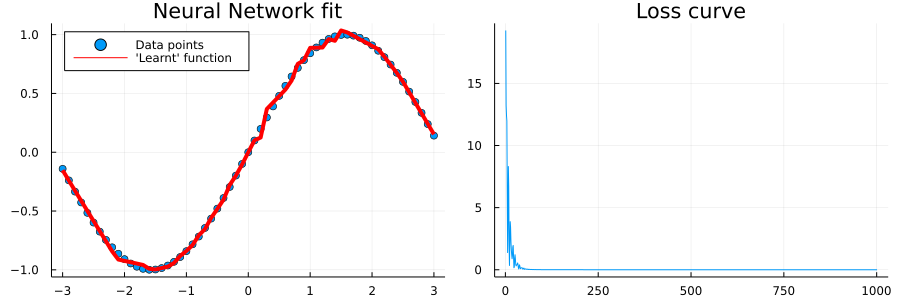

In [17]:
outputPlot = scatter(inputs, targetOutput,
    title = "Neural Network fit", label = "Data points", legend=:topleft
)
plot!(outputPlot, inputs, twoLayerNeuralNet(transpose(inputs))[:],
    label = "'Learnt' function", lw = 4, color = :red
)

lossCurvePlot = plot(lossCurve, title = "Loss curve", legend=:none)

plot(
    outputPlot,
    lossCurvePlot,
    size = (900,300)
)